# Spikey Tutorial

A narrow introduction to spikey with examples.

Table of Contents
---
1. Installation
2. Pieces of a Spiking Neural Network
3. Creating a Spiking Neural Network
4. Games
5. Training Loops
6. Gathering and working with results

```none
----------  -----------  ---------  -----
| Neuron |  | Synapse |  | Input |  | ...
----------  -----------  ---------  -----
       \         |         /
         \       |       /
--------   -------------
| Game |   |  Network  |
--------   -------------    ------------
   |____________/___________| Callback | --> Logger --> Reader
   |           /            ------------
-----------------
| Training Loop |
-----------------
        |
----------------------
| Aggregate Analysis |
----------------------
    ^       |
    L_______|
```

## Installation

First open a terminal in the root directory of your cloned Spikey repo.

You should see something like,
```bash
.../username/spikey>
```

Install all necessary dependencies,
```bash
pip install -r requirements.txt
```

Then since Spikey is not yet on pypi, install it locally via
```bash
pip install -e .
```

Spikey only needs to be reinstalled if you re-clone the repo or move it.

In [1]:
# After installation, restart this notebook and this import should work.
import spikey

## Pieces of a spiking neural network

Spiking neural networks are complex systems capable of learning in a similar way to the human brain.
These are systems of many unique parts: neurons, synapses, ... all of which are individually very simple, yet are able to cooperate and achieve the ability to understand the environment they are trained on. This is an emergent process. 

By default, this simulator expects a spiking neural network to consist of one of each of the following pieces,
```
Neuron: Neuron behavior.
Synapse: Learning rule implementation.
Weight: Datastructure to generate and manage the topology of the network. Connects individual inputs and neurons to eachother.
Input: Neurons with no incoming synapses and custom behaviors. Serve to encode sensory information from the environment to the network.
Readout: Function to translate output neuron's spike trains into actions.
Rewarder(ony for RL tools): Determines how much reward the network deserves for taking an action in a specific state.
```
```none
----------  -----------  ---------  -----
| Neuron |  | Synapse |  | Input |  | ...
----------  -----------  ---------  -----
       \         |         /
         \       |       /
           -------------
           |  Network  |
           -------------
```

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import os

In [3]:
# Each piece of the network has many parameters that need to be set.
# All parameters and their descriptions are listed in the parts NECESSARY_KEYS.
input_type = spikey.input.StaticMap
input_type.NECESSARY_KEYS

["n_inputs": "[<class 'int'>] Number of inputs.",
 "magnitude": "[(<class 'float'>, <class 'int'>)] Multiplier to each 0, 1 spike value.",
 "firing_steps": "[<class 'int'>] Number of network steps to fire for, -1 if all.",
 "input_pct_inhibitory": "[(<class 'float'>, <class 'int'>)] Pct of inputs that are inhibitory",
 "mapping": "[any] dict[tuple]->ndarray[processing_time, n_inputs, dtype=bool] State to fires mapping.."]

In [4]:
input_config = {
    'n_inputs': 2,
    'magnitude': 1,
    'firing_steps': -1,
    'input_pct_inhibitory': 0,
    'mapping': {0: [0, 0], 1: [0, 1], 2: [1, 0], 3: [1, 1]},
}
input = input_type(**input_config)
input.reset()

In [5]:
# Tell the input about the environment state
input.update(1)

# Input fire according to state
input()

array([0, 1])

In [6]:
neuron_type = spikey.neuron.Neuron
neuron_type.NECESSARY_KEYS

["magnitude": "[(<class 'float'>, <class 'int'>)] Magnitude of spike.",
 "n_neurons": "[<class 'int'>] Number of neurons in the network.",
 "neuron_pct_inhibitory": "[(<class 'float'>, <class 'int'>)] [0, 1] Percentage of inhibitory neurons.",
 "potential_decay": "[(<class 'float'>, <class 'int'>)] [0, 1] Percentage voltage loss on each tick.",
 "prob_rand_fire": "[(<class 'float'>, <class 'int'>)]  [0, 1] Probability each neuron will randomly fire",
 "refractory_period": "[<class 'int'>] Amount of time after spike neuron cannot fire.",
 "resting_mv": "[(<class 'float'>, <class 'int'>)] Neuron resting voltage.",
 "spike_delay": "[<class 'int'>] [0, 10] Units of time after hitting threshold to fire."]

In [7]:
# Each piece manages the whole set of such pieces, eg the Neuron part may contain 100+ neurons.
neuron_config = {
    'magnitude': 1.5,
    'n_neurons': 4,
    'neuron_pct_inhibitory': 0.,
    'potential_decay': .25,
    'prob_rand_fire': 0.,
    'refractory_period': 1,
    'resting_mv': 0.,
    'firing_threshold': 2.,
    'spike_delay': 0,
}
neuron = neuron_type(**neuron_config)
neuron.reset()

neuron.potentials

array([0., 0., 0., 0.], dtype=float16)

In [8]:
neuron += np.full(neuron_config['n_neurons'],  10)
fires = neuron >= neuron_config['firing_threshold']
fires

array([1.5, 1.5, 1.5, 1.5])

In [9]:
# Every piece of this simulator can be inhereted and extended or modified according to the user's needs.
# Each object contains a base template (eg spikey.weight.template.Weight) that defines bare minimum expected functionality.
from spikey.weight.template import Weight

class CustomWeight(Weight):
    NECESSARY_KEYS = Weight.extend_keys({
        'matrix': 'np.ma.array[n_inputs+n_neurons, n_neurons] Connections between individual inputs and neurons.'
    })
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._matrix = np.ma.copy(kwargs['matrix'])
        assert self._matrix.shape == (self._n_inputs+self._n_neurons, self._n_neurons), \
            "Incorrect weight shape!"
        self._clip_weights()

CustomWeight.NECESSARY_KEYS

["n_inputs": "[<class 'int'>] Number of inputs.",
 "n_neurons": "[<class 'int'>] Number of neurons in network.",
 "max_weight": "[(<class 'float'>, <class 'int'>)] Max synapse weight.",
 'matrix']

In [10]:
n_inputs = input_config['n_inputs']
n_neurons = neuron_config['n_neurons']
weight_config = {
    "n_inputs": n_inputs,
    "n_neurons": n_neurons,
    "max_weight": 1,
    'matrix': np.ones((n_inputs+n_neurons, n_neurons))
}
weight = CustomWeight(**weight_config)

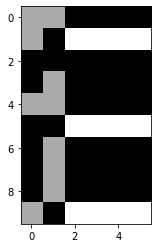

In [11]:
N_STEP = 10

input.reset()
neuron.reset()

spike_log = np.empty((N_STEP, n_inputs + n_neurons))
for s in range(N_STEP):
    input.update(np.random.randint(4))

    spikes = np.append(input(), neuron >= neuron_config['firing_threshold'])
    neuron.update()

    neuron += np.matmul(weight.matrix.T, spikes)

    spike_log[s] = spikes

plt.imshow(spike_log, cmap='gray')
plt.show()

## Creating a Spiking Neural Network

The Network object manages all of the pieces that go into an SNN and serves a simple interface for the user.

```none
----------  -----------  ---------  -----
| Neuron |  | Synapse |  | Input |  | ...
----------  -----------  ---------  -----
       \         |         /
         \       |       /
           -------------
           |  Network  |
           -------------
```

In [12]:
network_type = spikey.network.RLNetwork
network_type.NECESSARY_PARTS

["inputs": "[any] snn.input.Input",
 "neurons": "[any] snn.neuron.Neuron",
 "weights": "[any] snn.weight.Weight",
 "synapses": "[any] snn.synapse.Synapse",
 "readout": "[any] snn.readout.Readout",
 "modifiers": "[any, default=None] list of snn.modifier.Modifier",
 "rewarder": "[any] snn.reward.Reward"]

In [13]:
parts = {
    'inputs': spikey.input.StaticMap,
    'neurons': spikey.neuron.Neuron,
    'weights': spikey.weight.Manual,
    'synapses': spikey.synapse.RLSTDPET,
    'readout': spikey.readout.NeuronRates,
    'modifiers': None,
    'rewarder': spikey.reward.MatchExpected,
}

network_type.list_keys(**parts)

{
	"n_inputs": "[<class 'int'>] Number input neurons.",
	"n_outputs": "[<class 'int'>] n_outputs = n_neurons - n_body.",
	"processing_time": "[<class 'int'>] Number of network timesteps per game timestep.NOTE: processing_time must be greater than window!",
	"firing_threshold": "[(<class 'float'>, <class 'int'>)] Neuron voltage threshold to fire.",
	"n_neurons": "[<class 'int'>] Number of neurons in the network.",
	"magnitude": "[(<class 'float'>, <class 'int'>)] Multiplier to each 0, 1 spike value.",
	"firing_steps": "[<class 'int'>] Number of network steps to fire for, -1 if all.",
	"input_pct_inhibitory": "[(<class 'float'>, <class 'int'>)] Pct of inputs that are inhibitory",
	"mapping": "[any] dict[tuple]->ndarray[processing_time, n_inputs, dtype=bool] State to fires mapping..",
	"neuron_pct_inhibitory": "[(<class 'float'>, <class 'int'>)] [0, 1] Percentage of inhibitory neurons.",
	"potential_decay": "[(<class 'float'>, <class 'int'>)] [0, 1] Percentage voltage loss on each tick.",

In [14]:
network_config = {
    "n_inputs": 2,
	"n_neurons": 4,
	"n_outputs": 4,
	"processing_time": 10,

	"magnitude": 1,
	"resting_mv": 0,
	"firing_threshold": 2,
	"spike_delay": 0,
	"refractory_period": 1,
	"potential_decay": .25,
	"prob_rand_fire": 0,
	"neuron_pct_inhibitory": 0,

	"learning_rate": .01,
	"stdp_window": 20,
	"trace_decay": .25,
	"max_weight": 1,
	"matrix": np.random.uniform(size=(6, 4)),
	"inh_weight_mask": None,

	"mapping": type('input_map', (object,), {'__getitem__': lambda s, x: np.array(x)})(),
	"firing_steps": -1,
	"input_pct_inhibitory": 0,

    "n_pools": 0,
	"output_range": [0, 1],

	"reward_mult": 1,
	"punish_mult": -1,
	"expected_value": lambda state: np.sum(state) % 2,
}

network = network_type(**parts, **network_config)

In [15]:
# Alternative method, more readable when sharing to training loops and meta tools. Network template variables config and template parts have lower(lowest) priority than kwargs.
class network_template(network_type):
    config = network_config
    _template_parts = parts

network = network_template()

In [16]:
network.reset()

for s in range(10):
    output_rates = network.tick(np.random.randint(2, size=2))

    print(output_rates)

[0. 0. 0. 0.]
[0.5  0.5  0.25 0.5 ]
[0.   0.   0.25 0.25]
[0. 0. 0. 0.]
[0.   0.   0.25 0.25]
[0.   0.25 0.   0.25]
[0.   0.   0.25 0.25]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]


## Games / Environments

In Spikey, a game defines how spiking agents interact with the environment. They are very simple standalone objects. The structure is based on OpenAI gym environments which themselves can be converted to our type by the gym wrapper.

It is important to use Spikey's RL environments for perfect compatability with TrainingLoops, callbacks and meta analysis tools.

In [17]:
game_type = spikey.RL.Logic
game_type.NECESSARY_KEYS

["n_inputs": "[<class 'int'>] Number of inputs.",
 "expected_value": "[any] func(state) Expected action."]

In [18]:
game = game_type(preset='XOR')

In [19]:
# Are able to use kwargs similar to network, which take precedent over the preset
game_config = {
    'n_inputs': 2,
    'expected_value': lambda state: np.sum(state) % 2,
}
game = game_type(**game_config)

In [20]:
# An alternative method, hardcoded game_template.config has lower(lowest) priority than presets and kwargs.
class game_template(game_type):
    config = game_config

game = game_template()
_ = game.seed(0)

In [21]:
state = game.reset()
for _ in range(10):
    action = np.random.randint(2, dtype=np.bool)

    state, reward, done, info = game.step(action)
    print(state, '\t->', action)
    if done:
        break

(False, False) 	-> False
(True, False) 	-> True
(False, False) 	-> False
(True, True) 	-> False
(False, False) 	-> True
(True, False) 	-> True
(False, True) 	-> False
(False, False) 	-> True
(False, True) 	-> False
(True, False) 	-> True


## Training Loops

Spiking neural networks are trained by letting them interact with some environment for a significant amount of time, then giving them feedback of their performance via some reinforcement or supervision signal. For the vast majority of experiments the exact same training loop code can be used.

Spikey provides both pre-built, distributable training loops and the ability for the user to define their own.

```none
----------  -----------  ---------  -----
| Neuron |  | Synapse |  | Input |  | ...
----------  -----------  ---------  -----
       \         |         /
         \       |       /
--------   -------------
| Game |   |  Network  |
--------   -------------
   |            /
   |           /
-----------------
| Training Loop |
-----------------
```

In [22]:
loop_type = spikey.core.GenericLoop
loop_type.NECESSARY_KEYS

["n_episodes": "[<class 'int'>] Number of episodes to run.",
 "len_episode": "[<class 'int'>] Length of episode."]

In [23]:
# Using pre-built, distributable training loop
experiment_params = {
    **network_config,
    **parts,
    **game_config,
    "n_episodes": 1,
    "len_episode": 10,
}
experiment = loop_type(network_type, game_type, experiment_params)

In [24]:
# Creating distributable training loop
class CustomLoop(spikey.core.TrainingLoop):
    NECESSARY_KEYS = spikey.core.TrainingLoop.extend_keys(
        {
            "n_episodes": "int Number of episodes to run,",
            "len_episode": "int Length of episode.",
        }
    )
    def __call__(self, **kwargs) -> (object, object, dict, dict):
        game = self.game_template(**self.params)
        network = self.network_template(game=game, **self.params)

        for e in range(self.params["n_episodes"]):
            network.reset()
            state = game.reset()

            for s in range(self.params["len_episode"]):
                action = network.tick(state)

                state, _, done, __ = game.step(action)

                if hasattr(network, 'reward') and callable(getattr(network, 'reward')):
                    reward = network.reward(state, action)

                if done:
                    break

        return network, game, {}, {}

not_experiment = CustomLoop(network_type, game_type, experiment_params)

In [25]:
# Fully custom training loop
# NOTE: This method not recomended if you intend to use it in any meta analysis tools.
game = game_template()
network = network_template(game=game)

for e in range(experiment_params["n_episodes"]):
    network.reset()
    state = game.reset()

    for s in range(experiment_params["len_episode"]):
        action = network.tick(state)

        state, _, done, __ = game.step(action)

        if hasattr(network, 'reward') and callable(getattr(network, 'reward')):
            reward = network.reward(state, action)

        print(state, '\t->', action)

        if done:
            break

(False, False) 	-> [0.25 0.25 0.5  0.25]
(False, False) 	-> [0. 0. 0. 0.]
(True, True) 	-> [0. 0. 0. 0.]
(True, True) 	-> [0.5  0.25 0.   0.25]
(False, False) 	-> [0.25 0.25 0.75 0.  ]
(True, False) 	-> [0. 0. 0. 0.]
(True, True) 	-> [0.5 0.  0.5 0.5]
(True, False) 	-> [0.5 0.5 0.5 0.5]
(True, True) 	-> [0.25 0.25 0.5  0.  ]
(True, True) 	-> [0.5 0.5 0.5 0.5]


In [26]:
# Results and info come from callback(below)
# Results is data that can be loaded to a table, info is things that require more analysis
experiment.reset()
network, game, results, info = experiment()

print(network)
print(game)
print(results)

{'version': '0.0.0', 'total_time': 0.030421018600463867, 'n_episodes': 1, 'len_episode': 10}


## Callback

Callbacks are the core of the experiment management of Spikey. Callback is responsible for tracking preset and user targeted signals. Any information gathered by the callback can be logged to file and read later using the respective logger and reader.

```none
--------   -------------
| Game |   |  Network  |
--------   -------------    ------------
   |____________/___________| Callback | --> Logger --> Reader
   |           /            ------------
-----------------
| Training Loop |
-----------------
```

In [27]:
# A standalone callback working on an arbitrary function, demonstrating how it is used by network and game
callback = spikey.core.ExperimentCallback()
callback.random = lambda *a: None  # Define binding

## First add some signal trackers that trigger when binding is called in form
# callback.track(
#       binding_fn_name,
#       output location = 'result'/'info',
#       name for tracker,
#       target in form ['network/game/experiment_params', 'obj1', 'obj2', 'var_name'] or ['arg_#'],
#       method = 'list'/'scalar,       
# )

# Callback update a scalar variable in results dictionary whenever binding called
callback.track("random", "results", "demo_1", ['arg_0'], "scalar")

# Callback append to list in info dictionary whenever binding called
callback.track("random", "info", "demo_2", ['arg_0'], "list")

callback.reset()

def random(arg1):
    callback.random(arg1)

In [28]:
random(0)

print(f"demo_1: {callback.results['demo_1']}, demo_2: {callback.info['demo_2']}")

demo_1: 0, demo_2: [0]


In [29]:
callback.reset()
print(f"demo_1: {callback.results['demo_1']}, demo_2: {callback.info['demo_2']}")

for i in range(5):
    random(i)

print(f"demo_1: {callback.results['demo_1']}, demo_2: {callback.info['demo_2']}")

demo_1: 0, demo_2: []
demo_1: 4, demo_2: [0, 1, 2, 3, 4]


In [30]:
# Further callback custom tracking
callback = spikey.core.RLCallback()

# Object member variable
callback.track("network_init", "info", "weights_original", ["network", "synapses", "weights", "matrix"], "scalar")
callback.track("training_end", "results", "len_episode", ["experiment_params", "len_episode"], "scalar")

# Function argument
callback.track("network_reward", "info", "step_rewards", ["arg_2"], "list")

# Arbitrary function
callback.track("network_init", "info", "start_time", time, "scalar")

In [31]:
experiment_params = {
    **network_config,
    **parts,
    **game_config,
    "n_episodes": 1,
    "len_episode": 10,
}
experiment = loop_type(network_type, game_type, experiment_params)

In [32]:
# Log from tl and base
# This will save to a json file with members
# network: All network parts and serializable(json safe) parameters
# game: All game serializable(json safe) parameters.
# results: Any results that can be directly read into a table, typically from a callback
# info: Any other data relevant for analysis, typcially from a callback
filename = 'tutorial_log.json'

experiment.reset()
network, game, results, info = experiment(callback=callback)

callback.log(filename=filename)
# alternatively, spikey.logging.log(network, game, results, info, filename=filename)

Failed to get experiment_params.len_episode in <class 'spikey.core.callback.RLCallback'>: 'len_episode'.


In [33]:
# Reader usage
reader = spikey.logging.Reader('.', [filename])

# For all items in network, game, result
reader.df

,n_inputs,n_neurons,n_outputs,processing_time,magnitude,resting_mv,firing_threshold,spike_delay,refractory_period,potential_decay,...,len_episode,name,matrix,output_range,modifiers,callback,inh_weight_mask,mapping,total_time,version
0,2.0,4.0,4.0,10.0,1.0,0.0,2.0,0.0,1.0,0.25,...,{},OR,"[[0.07206391916533461, 0.6901712514810547, 0.9...","[0.0, 1.0]",None,0.0,None,None,0.05479,0.0.0


In [34]:
# For specific items in any section
reader['episode_lens']

['[10]']